# Analysis of the lobby European lobby network

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
from collections import Counter
import networkx as nx
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
from networkx.algorithms import bipartite
import json
import numpy as np
import scipy.stats
import xgi
from sklearn.metrics import normalized_mutual_info_score
from IPython.display import clear_output
from tqdm.auto import tqdm
import joblib

from european_commission import EuropeanCommission
from utils import split_column
#from centrality import 
#from core import 
#from utils.ols import 
#from assortativity import

#TODO Remove create only one file for centralities with sub_hypergraph centralitie having a sufix 'sub'. Same for core decompotition 

/home/azaiez/Documents/These/european_commission/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Load Data

In [65]:

def add_centralities(EC, metrics_path: str) -> pd.DataFrame:
    """Load centrality CSV and merge into entities."""
    cent = pd.read_csv(f"{metrics_path}/node_centrality.csv", index_col='Name')
    cent.index = cent.index.map(lambda x: EC.mapper.get(x, x))
    EC.entities.loc[cent.index, cent.columns] = cent
       
def load_core():
  
    # #Core
    with open( '../out/metrics/core_multiedgesTrue.json') as json_file:
        core= json.load(json_file )    
    core_true = { int(m) : {int(k) :  [set(component) for component in core[m][k]] for k, value in core[m].items() } for m in core.keys()}
    
    with open( '../out/metrics/core_multiedgesFalse.json') as json_file:
        core= json.load(json_file )    
    core_false = { int(m) : {int(k) :  [set(component) for component in core[m][k]] for k, value in core[m].items() } for m in core.keys()}
    
    with open( '../out/metrics/core_sub_multiedgesTrue.json') as json_file:
        core = json.load(json_file )
    core_sub_true = { int(m) : {int(k) :  [set(component) for component in core[m][k]] for k, value in core[m].items() } for m in core.keys()}

    with open( '../out/metrics/core_sub_multiedgesFalse.json') as json_file:
        core = json.load(json_file )
    core_sub_false = { int(m) : {int(k) :  [set(component) for component in core[m][k]] for k, value in core[m].items() } for m in core.keys()}

    return core_true, core_false, core_sub_true, core_sub_false

EC = EuropeanCommission('../data/', reload = False, fuzzy_ratio = 70)
add_centralities(EC, '../out/metrics/')
core_true, core_false, core_sub_true, core_sub_false = load_core()

## Duplicated meetings
duplicated_df = EC.meetings[['Name of cabinet', 'Name of DG', 'EC member', 'Title of EC representative', 'Date', 'TR ID', 'Name of interest representative','Location', 'Subject' ]]

duplicated_df = duplicated_df[duplicated_df.duplicated(['Date', 'TR ID'] ,  keep = False,)].sort_values(['Date', 'TR ID'])
duplicated_df.to_csv('../out/duplicated.csv',  date_format= '%x')


/home/azaiez/Documents/These/european_commission/src/orbis.py:96: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.company_data.replace('n.a.', np.nan, inplace = True)
/home/azaiez/Documents/These/european_commission/src/orbis.py:97: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.company_data.replace('-', np.nan , inplace = True)


In [34]:
# Load configuration model data
directory = '../out/simulations/'
results_mcmc = []
for file in tqdm(os.listdir(directory)):
    data = joblib.load(os.path.join(directory, file))
    results_mcmc.append(data)
df_sim = pd.DataFrame(results_mcmc)


  0%|          | 0/600 [00:00<?, ?it/s]

## Save file for regression

In [66]:
df = EC.get_orga()[[ 
    'TR Name', 
    'Category of registration', 
    'Degree', 
    'Hypercoreness_False', 'Hypercoreness_sub_False', 
    'Hypercoreness_True', 'Hypercoreness_sub_True',
    'Hypercoreness_G_False', 'Hypercoreness_G_sub_False', 
    'Hypercoreness_G_True', 'Hypercoreness_G_sub_True',
    'TR Country',
    'Members FTE', 
    'Level of interest',  
    'Assets',
    'Revenue', 
    'Nb employees', 
    'NACE' ]].copy()

#Split catagorial data

levels = split_column(df, 'Level of interest', prefix = 'Level')
df.drop('Level of interest', axis = 1, inplace = True)
# fields = split_column(df , 'Fields of interest', prefix = 'Field')
# df.drop('Fields of interest', axis = 1, inplace = True)

df = pd.concat( [df , levels], axis = 1)

df.to_csv('../out/reg_data.csv', index = False)

#fields.to_csv(path +'Programs/fields.csv', index = False)

## Degree and size distribution

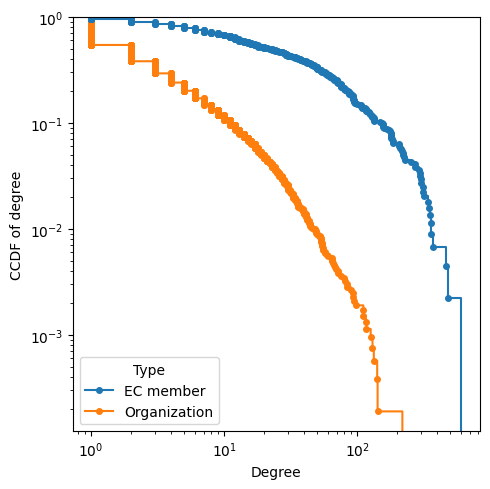

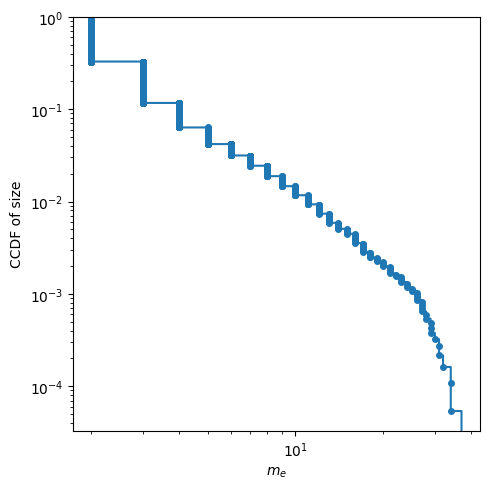

In [6]:


feature         = 'Degree'
node_attribute  = 'Type'

# node‐degree CCDF by type
fig, ax = plt.subplots(figsize=(5,5))
sns.ecdfplot(
    data=EC.entities.dropna(subset=[feature, node_attribute]),
    x=feature,
    hue=node_attribute,
    complementary=True,
    ax=ax,
    marker='o',  
    markersize=4,
    linestyle = '-'
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(feature)
ax.set_ylabel(f'CCDF of {feature.lower()}')
plt.tight_layout()
fig.savefig(f'../out/Figures/Node_{feature}.pdf')


feature  = 'Size'
fig , ax = plt.subplots(figsize = (5,5))
sns.ecdfplot(
    x=EC.H.size().values(),
    complementary=True,
    ax=ax,
    marker='o',  
    markersize=4,
    linestyle = '-'
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'$m_e$')
ax.set_ylabel(f'CCDF of {feature.lower()}')
plt.tight_layout()
fig.savefig(f'../out/Figures/Edge_{feature}.pdf')

In [7]:
import pandas as pd
import scipy.stats

# Create a DataFrame for node descriptions
df = EC.entities.groupby(['Type', 'Category of registration'])['Degree'].agg(
    Count='count',
    Total_Degree='sum',
    Mean_Degree = 'mean',
    Degree_Skewness=lambda x: scipy.stats.skew(x)
).astype({'Total_Degree': 'int'})


# Sort by Count within each Type
df = df.groupby('Type', group_keys=False).apply(lambda group: group.sort_values('Count', ascending=False))

# Export LaTeX table
print(df)
print(df.to_latex(float_format="%.2f"))

# Calculate degree proportions for specific categories
categories = {
    'Companies and groups': df.loc[('Organization', 'Companies and groups'), 'Total_Degree'],
    'Trade and business associations': df.loc[('Organization', 'Trade and business associations'), 'Total_Degree'],
    'Non-governmental organisations': df.loc[('Organization', 'Non-governmental organisations, platforms and networks and similar'), 'Total_Degree'],
}
total_degree_org = df.loc['Organization', 'Total_Degree'].sum()

# Print proportions
print('Proportion Companies and groups degree:', categories['Companies and groups'] / total_degree_org)
print('Proportion of business association degree:', categories['Trade and business associations'] / total_degree_org)
print('Proportion of non-Business NGO degree:', categories['Non-governmental organisations'] / total_degree_org)
print('Remaining categories:', 1 - sum(categories.values()) / total_degree_org)


                                                                 Count  \
Type         Category of registration                                    
EC member    Cabinet member                                        361   
             Director-General                                       52   
             Commissioner                                           30   
Organization Companies and groups                                 1732   
             Non-governmental organisations, platforms and n...   1314   
             Trade and business associations                       983   
             Trade unions and professional associations            316   
             Think tanks and research institutions                 240   
             Professional consultancies                            190   
             Other organisations, public or mixed entities         158   
             Academic institutions                                 110   
             Associations and networks

## Correlation btw hyperedge centralities


In [8]:
pd.read_csv('../out/metrics/edge_centrality.csv').corr()['Betweenness']['Cardinality']

np.float64(0.7354162435716233)

# Micro-scale edge patterns

## Assortativity

In [9]:
# oveall_assortativity
nb_itt= 100

degree_dict = dict(EC.H.degree())

overall , ec_ec, ec_orga , orga_orga = [], [], [], []
for _ in range(nb_itt):
    overall.append(overall_assortativity(EC.meetings, degree_dict))
    
    ec_ec.append(intra_assortativity(EC.meetings, 'EC member', degree_dict))
    orga_orga.append(intra_assortativity(EC.meetings, 'TR ID', degree_dict))

    ec_orga.append(EC_Orga_assortativity(EC.meetings, degree_dict))
    if _ % 10 == 0:
        print(_)

print('average assortativity', np.mean(overall), 'std=', np.std(overall))
print('average assortativity', np.mean(ec_ec), 'std=', np.std(ec_ec))
print('average assortativity', np.mean(orga_orga), 'std=', np.std( orga_orga))
print('average assortativity', np.mean(ec_orga), 'std=', np.std(ec_orga))

NameError: name 'overall_assortativity' is not defined

## Attribute mixing matrix

In [10]:
def attribute_mixing( node_attribute : str, edge_attribute : str, node_sort_by= 'Degree', edge_sort_by= 'Name of cabinet'):
    
    # split tuples 
    meetings = EC.meetings.explode('TR ID').explode(edge_attribute).reset_index().copy()
    meetings[node_attribute] = meetings['TR ID'].apply(lambda x : EC.entities.loc[x ,node_attribute])
    df = meetings.groupby([edge_attribute, node_attribute]).count()['index'].unstack()
    
    # Reorder columns and rows
    categories = list(EC.get_orga().groupby(node_attribute)[node_sort_by].sum().sort_values(ascending = False).index)
    commissions = list( EC.meetings.explode(edge_attribute).value_counts(edge_attribute).index)
    
    df = df[categories]
    df = df.reindex(commissions)
    return df




/tmp/ipykernel_116190/2998019724.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


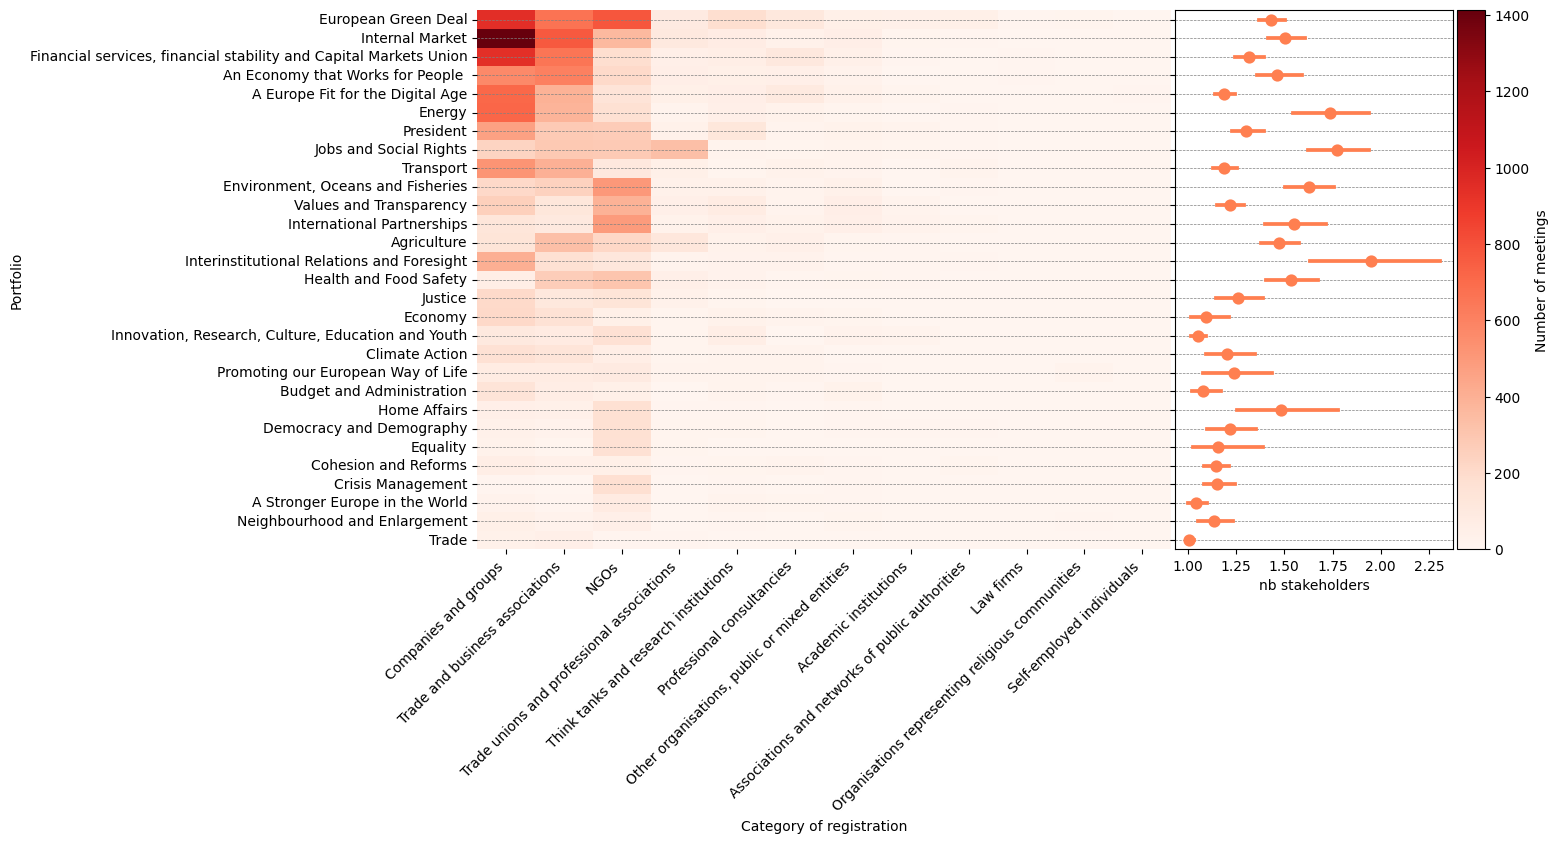

In [12]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

    
mapper = {orga : category for orga , category in zip (EC.entities.index , EC.entities['Category of registration'])}
# business_entities = df'Category of registration'].isin([ 'Companies and groups', 'Trade unions and professional associations'])
# mapper = {orga: category for orga , category in zip (business_entities.index ,  business_entities )}

df = attribute_mixing('Category of registration', 'Department')
df_portfolio = pd.read_csv('../data/commissions_portfolio.csv',  usecols = ['Portfolio', 'Name of cabinet'],index_col = 'Name of cabinet',)
df['Portfolio'] =df_portfolio
df = df.groupby('Portfolio').sum()
df = df.reindex(df.sum(axis = 1).sort_values(ascending = False).index)


meetings = EC.meetings.copy()
df_exploded = meetings.explode('Department')[['TR ID', 'Department']].copy()
df_exploded['nb stakeholders'] = df_exploded['TR ID'].apply(len)
df_exploded['Department'] =df_exploded['Department'].apply(lambda x : df_portfolio.loc[x])

# Create a gridspec to allow placing the colorbar outside the third plot
fig = plt.figure(figsize=(13, 7))
gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1,  0.1], wspace=0.012)

# Set up the three subplots
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

# Plot the heatmap
shorten = {'Non-governmental organisations, platforms and networks and similar': 'NGOs',
           'Organisations representing churches and religious communities': 'Organisations representing religious communities'}
x_ticks = [shorten.get(cat, cat) for cat in df.columns]
y_label_df = df.index
y_ticks = list(y_label_df)

heatmap = sns.heatmap(df,
                      cmap='Reds',
                      xticklabels=x_ticks,
                      yticklabels=y_ticks,
                      ax=ax0,
                      cbar=False)
ax0.tick_params(axis='x', rotation=45)
ax0.set_xticklabels(ax0.get_xticklabels(), ha='right')


ax1.set_yticklabels([])    
# Plot the point plots
sns.pointplot(data=df_exploded,
              x='nb stakeholders',
              y=pd.Categorical(df_exploded['Department'],
                               categories=df.index,
                               ordered=True),
              linestyle='none',
              color = 'coral',
              ax=ax1)


# Add the color bar on the right of the third subplot
cbar_ax = fig.add_subplot(gs[2])  # Create an axis for the colorbar
cbar = fig.colorbar(heatmap.get_children()[0], cax=cbar_ax)  # Link the heatmap to the colorbar
cbar_ax.set_ylabel('Number of meetings', rotation=90)  # Optionally, add a label for the color bar

# Add grid to the point plot subplots
for a in [ax0, ax1]:
    a.grid(True, which='both', axis='y', color='gray', linestyle='--', linewidth=0.5)

fig.tight_layout()
plt.savefig('../out/Figures/attribute_mixing_matrix.pdf',  bbox_inches='tight')

## Meetings Diversity

In [72]:
from centrality import entropy_meeting
mapper = {orga : category for orga , category in zip (EC.entities.index , EC.entities['Category of registration'])}
bins = np.linspace(0, 1, 21)  

# Empirical
df = pd.DataFrame({ 'TR ID' : EC.meetings['TR ID']})
df = df[df['TR ID'].apply(len) >1 ]
df['TR ID'] = df['TR ID'].apply(lambda x: tuple(mapper.get(orga, orga) for orga in x  ))
df['Entropy'] = df['TR ID'].apply(lambda x : entropy_meeting(x))


# Random 
sim_hists = []
ents = []
ec_members = set(EC.entities[EC.entities['Type'] == 'EC member'].index)
mapper = {orga : category for orga , category in zip (EC.entities.index , EC.entities['Category of registration'])}

for H in df_sim.query("mode=='orga' & multiedges==True")['H']:
    X = H.copy()
    #X.remove_nodes_from(ec_members)
    df_ent_rand = pd.DataFrame({'edge': [e for e in X.edges.members() if len(e) > 1]})
    df_ent_rand['edge'] = df_ent_rand['edge'].apply(lambda x: tuple(mapper.get(orga, orga) for orga in x  ))
    df_ent_rand['Entropy'] = df_ent_rand['edge'].apply(lambda x : entropy_meeting(x))
    ents.append(list(df_ent_rand['Entropy']))


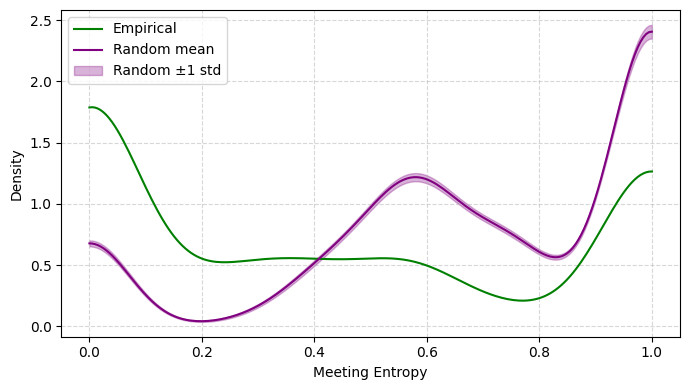

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Empirical entropies
emp_ents = df['Entropy'].values

sim_ents = ents

# Evaluation points
xs = np.linspace(0, 1, 200)

# Compute empirical KDE
kde_emp = gaussian_kde(emp_ents)
emp_vals = kde_emp(xs)

# Compute random KDEs
kde_matrix = np.vstack([gaussian_kde(sim)(xs) for sim in sim_ents])

# Mean and std across simulations
rand_mean = kde_matrix.mean(axis=0)
rand_std  = kde_matrix.std(axis=0)

# Plot
plt.figure(figsize=(7,4))
plt.plot(xs, emp_vals, label='Empirical', color='green')
plt.plot(xs, rand_mean, label='Random mean', color='purple')
plt.fill_between(xs,
                 rand_mean - rand_std,
                 rand_mean + rand_std,
                 color='purple', alpha=0.3,
                 label='Random ±1 std')

plt.xlabel('Meeting Entropy')
plt.ylabel('Density')
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../out/Figures/meeting_diversity.pdf')


## Z-score/Category representation in small vs large meetings 

In [46]:
def enrichment_zscores(H,
                    node_table,
                    cat_col="Category",
                    big_k=10,
                    small_k=3):
    """
    Enrichment analysis of node categories in large vs. small hyperedges.

    Parameters
    ----------
    H : xgi.Hypergraph
        Hypergraph whose nodes match the index of `node_table`.
    node_table : pd.DataFrame
        Must contain a categorical column `cat_col` with node types.
        Its index should be node IDs used in H.
    cat_col : str
        Column name for the node category.
    big_k : int
        An edge is *large* if |e| >= big_k.
    small_k : int
        An edge is *small* if |e| <= small_k.

    Returns
    -------
    pd.DataFrame
        Columns: ['category', 'class', 'obs', 'exp', 'z'] where class ∈ {'large','small'}.
    """
    all_edges = np.concatenate([list(H.edges.members(e)) for e in H.edges])
    node_cats = dict(zip(node_table.index, node_table[cat_col]))
    cat_counts_all = Counter([node_cats[node] for node in all_edges])
    N_all = len(all_edges)
    size = H.size()
                        # global frequency

    # -----------------------------------------------------------------
    # 2. Split edges into classes
    # -----------------------------------------------------------------
    large_edges = [e for e in H.edges if size[e] >= big_k]
    small_edges = [e for e in H.edges if size[e] <= small_k]

    # helper: count category occurrences in a list of edges
    def cat_count(edges):
        nodes_in_edges = np.concatenate([list(H.edges.members(e)) for e in edges])
        cat_count_edges = Counter([node_cats[node] for node in nodes_in_edges])
        return cat_count_edges


    cat_counts_large = cat_count(large_edges)
    cat_counts_small = cat_count(small_edges)

    N_large = len(np.concatenate([list(H.edges.members(e)) for e in large_edges]))
    N_small = len(np.concatenate([list(H.edges.members(e)) for e in small_edges]))

    # -----------------------------------------------------------------
    # 3. Compute z-scores
    # -----------------------------------------------------------------
    records = []
    for c in  [c for c,_ in cat_counts_all.most_common()]:
        for cls, obs_counts, N_cls in [
            ("large", cat_counts_large, N_large),
            ("small", cat_counts_small, N_small),
        ]:
            obs = obs_counts.get(c, 0)
            exp = N_cls * cat_counts_all[c]/N_all
            z   = (obs - exp) / np.sqrt(exp) if exp > 0 else np.nan
            records.append({"category": c,
                            "class": cls,
                            "obs": obs,
                            "exp": exp,
                            "z": z})
    return pd.DataFrame(records)


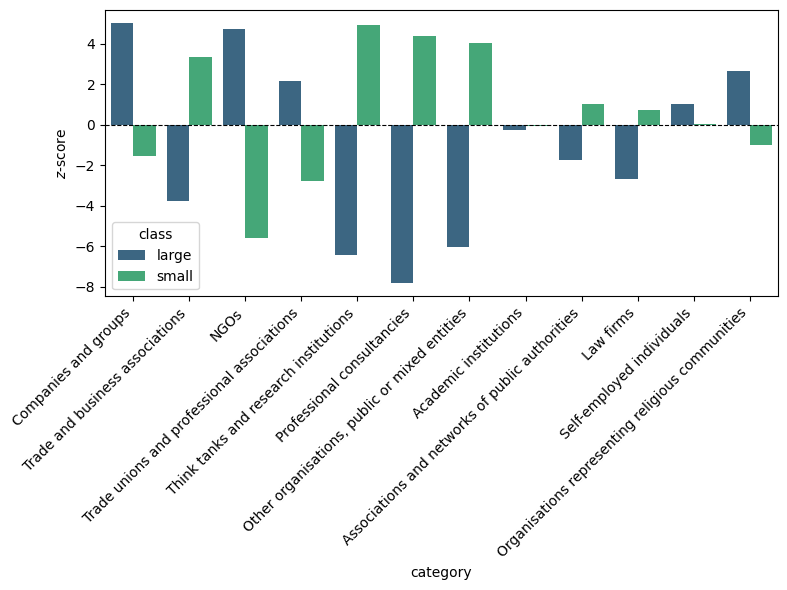

In [47]:

H = EC.sub_hypergraph().copy()
node_table = EC.entities.copy()
cat_col = 'Category of registration'
big_k = 5
small_k = 2

result = enrichment_zscores(H,
                            node_table,
                            cat_col= cat_col,
                            big_k=big_k,
                            small_k=small_k)

# quick view
#print(result.sort_values(["class", "z"], ascending=[True, False]))
shorten = {'Non-governmental organisations, platforms and networks and similar': 'NGOs',
           'Organisations representing churches and religious communities': 'Organisations representing religious communities'}
x_ticks = {cat: shorten.get(cat, cat) for cat in result['category'].dropna().unique()}


# optional: bar plot of z-scores
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.barplot(data=result,
            x="category",
            y="z",
            hue="class",
            palette="viridis")
plt.axhline(0, ls="--", color="k", lw=0.8)
plt.ylabel("$z$-score")
plt.xticks(list(x_ticks.keys()), labels=list(x_ticks.values()), rotation=45, ha="right")
plt.tight_layout()
plt.savefig(
    '../out/Figures/z_score_cat_edge_size.pdf',
    bbox_inches='tight'
)

## Transversality

In [19]:

## Transversality of node
def Transversality(node):
    c = Counter(EC.meetings.loc[ list(EC.H.nodes.memberships(node))]['Department'].explode())
    d = len(c)
    pk = [c[item]/d for item in c.keys()]
    return entropy(pk, base =  sum(c.values()))
    
feature = 'Transversality'
#EC.entities[feature]= EC.entities[feature].fillna(0)

EC.entities[feature] = EC.get_orga()[EC.get_orga()['Degree']>1].apply(lambda x :Transversality(x.name), axis =1)
#EC.entities.dropna(subset = 'NACE').groupby('NACE')[feature].mean()    


cat = dict(zip(EC.entities.index , EC.entities['Category of registration']))
#cat.update(dict(zip (EC.get_companies().index , EC.get_companies()['NACE'])))
data = pd.DataFrame({'Category' : list(cat.values()) }, index = list(cat.keys()))
data = pd.concat([data, EC.entities[feature]], axis = 1)

order = list(EC.entities.groupby(['Type','Category of registration']).sum().loc['Organization'].sort_values('Degree', ascending = False).index)
#order += list(EC.entities['NACE'].dropna().sort_values().unique())
#order.remove('Companies and groups')


fig, ax = plt.subplots(figsize = (10,10)) 

palette = sns.color_palette("Spectral", len(order ))
sns.violinplot(data = data.loc[EC.get_orga()[EC.get_orga()['Degree']>1].index], x = feature, y = 'Category',density_norm  = 'width', palette = palette, order = order , legend =False )  
ax.yaxis.set_ticks_position("right")
plt.tight_layout() 

plt.grid()

NameError: name 'entropy' is not defined

## Hypercore decomposition

### Rich club Coefficient

In [ ]:
from rich_club import rich_club, normalized_rich_club

#df_sim['rich_club'] = df_sim['H'].apply(lambda H :rich_club(H.edges.members()))
results_rc = []
for mode in [ 'full', 'subdim', 'orga']:
    for multiedges in [True, False]:        
        result = normalized_rich_club(df_sim, mode, multiedges, EC)
        results_rc.append(result)

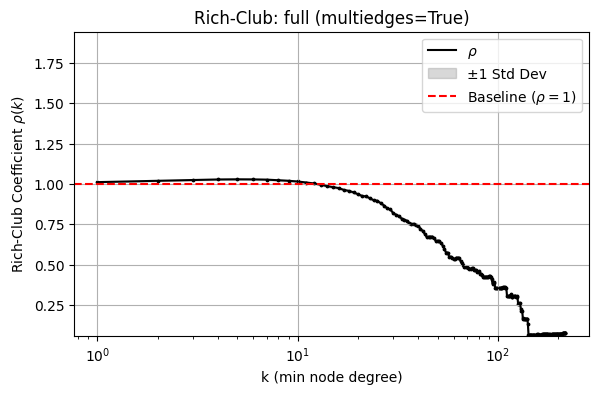

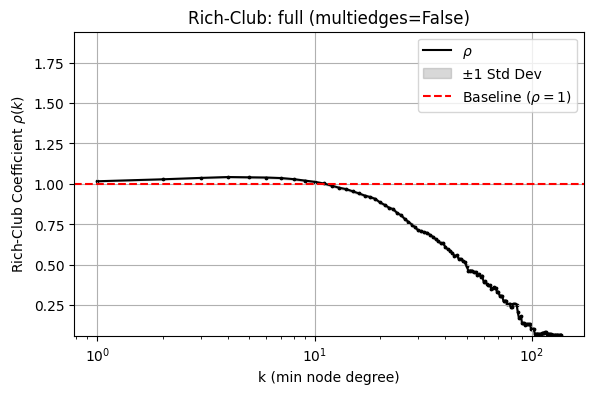

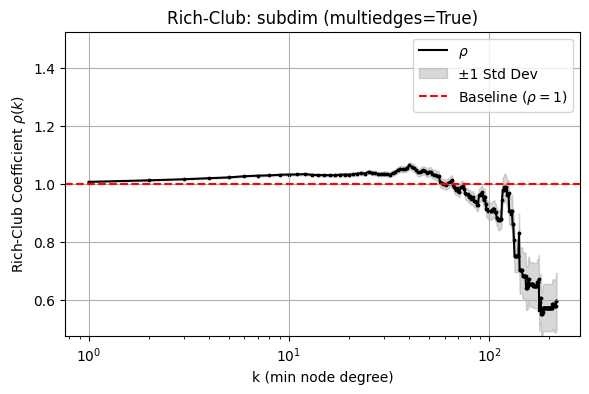

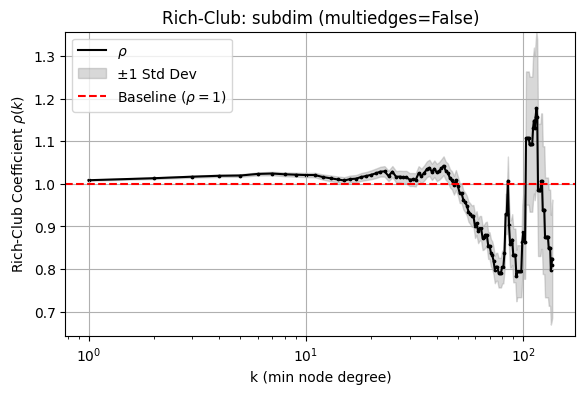

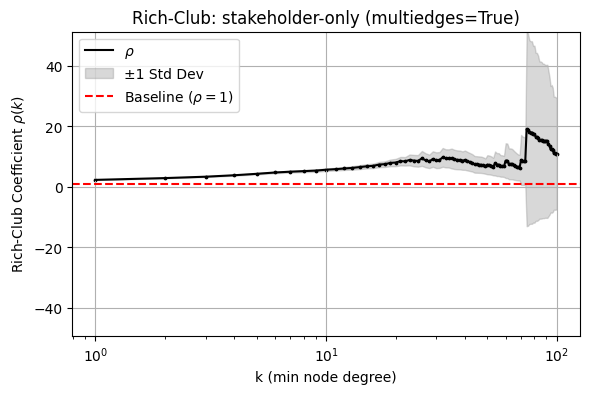

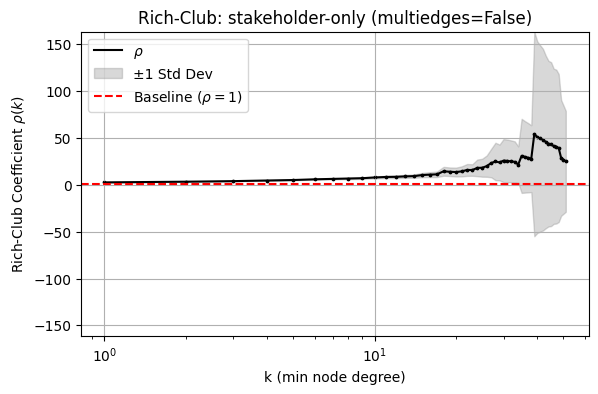

In [33]:
for result in results_rc:
    mode, multiedges, rho, rho_err, rho_std, mean = result.values()
    lower_bound = rho - rho_std
    upper_bound = rho + rho_std

    plt.figure(figsize=(6, 4))
    plt.plot(rho.index, rho, color='black', label=r"$\rho$")
    plt.fill_between(rho.index, lower_bound, upper_bound, color='gray', alpha=0.3, label='±1 Std Dev')
    plt.axhline(1.0, ls='--', color='red', label= r'Baseline $(\rho = 1$)')
    plt.scatter(rho.index, rho, s=3, color='black')
    plt.xlabel("k (min node degree)")
    plt.ylabel(r"Rich-Club Coefficient $\rho(k)$")
    if mode == 'orga':
        plt.title(f"Rich-Club: stakeholder-only (multiedges={multiedges})")
    else:
        plt.title(f"Rich-Club: {mode} (multiedges={multiedges})")
        
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xscale('log')
    # compute symmetric y‐limits around 1
    ymin = min(lower_bound.min(), rho.min())
    ymax = max(upper_bound.max(), rho.max())
    delta = max(1.0 - ymin, ymax - 1.0)
    plt.ylim(1.0 - delta, 1.0 + delta)
    # save figure
    
    plt.savefig(f'../out/Figures/rho_{mode}_multiedges_{multiedges}.pdf')





### Core Connectedness

Text(0.5, 1.0, '$ \\frac{N_1^{k,m}}{N_1^{k,m} +N_2^{k,m}} $')

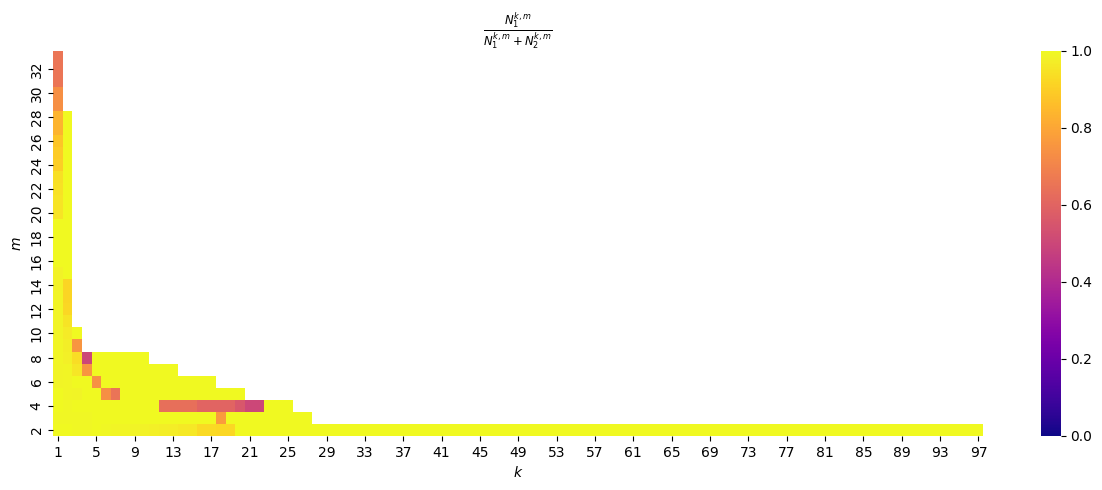

In [61]:
from core import proportion_largest_cc_size, k_m_core_size

suffix = '_sub_True'
if suffix == 'True':
    _core = core_true
elif suffix == 'False':
    _core = core_false
elif suffix =='_sub_True':
    _core = core_sub_true
elif suffix =='_sub_False':
    _core = core_sub_false

    
core_connectedness, M_vals, K_vals = proportion_largest_cc_size(_core)

n_k_m, M_vals, K_vals = k_m_core_size(_core)

df = pd.DataFrame(core_connectedness, index=M_vals, columns=K_vals)


cmap = plt.cm.plasma
fig, ax =plt.subplots(figsize =(15,5))
sns.heatmap( df, cmap =cmap, xticklabels = 4, vmin=0, vmax =1 )
plt.gca().invert_yaxis()
plt.xlabel('$k$')
plt.ylabel('$m$')
plt.title (r'$ \frac{N_1^{k,m}}{N_1^{k,m} +N_2^{k,m}} $')
#plt.title (r'$ n_{k,m}$')
#plt.savefig( f'../out/Figures/n_k_m_heatmap{suffix}.pdf')
#plt.savefig( f'../out/Figures/km_hypercore_connectedness{suffix}.pdf')





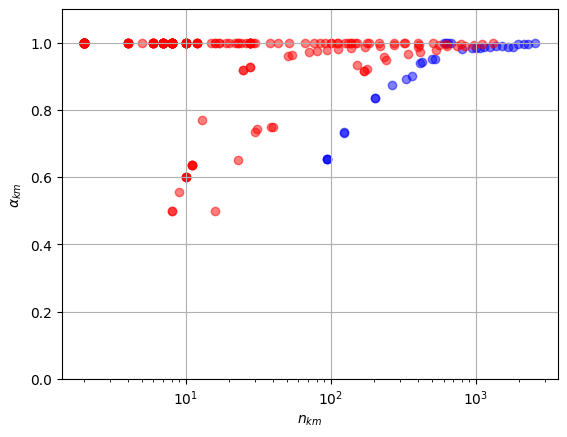

In [62]:
plt.scatter(n_k_m[:,0].flatten(), core_connectedness[:,0].flatten(), alpha = 0.5, color = 'b')

n_k_m_restric =np.delete(n_k_m, 0, axis = 1)
core_connec_restric = np.delete(core_connectedness, 0, axis=1)

plt.scatter(n_k_m_restric.flatten(), core_connec_restric.flatten(), alpha = 0.5, color = 'r')
plt.ylim([0,1.1])
plt.xlabel(r'$n_{km}$')
plt.ylabel(r'$\alpha_{km} $')
plt.xscale('log')
plt.grid()
#plt.savefig(f'../out/Figures/alpha_vs_nkm{suffix}.pdf')

## Core Composition

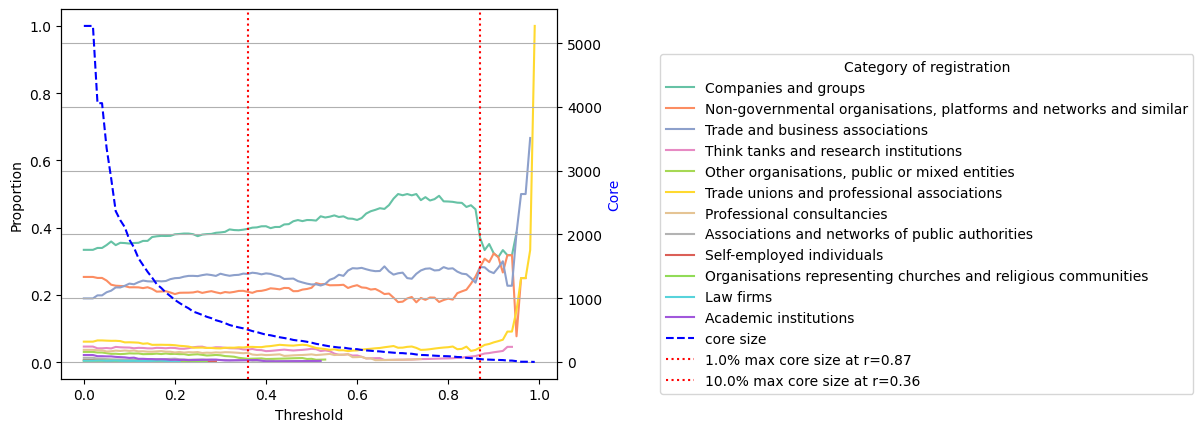

In [64]:
#%matplotlib widget
feature = 'Category of registration'

entities  = EC.get_orga()
suffix = ''
multiedges = False
centrality = f'Hypercoreness_{suffix}_{multiedges}'

r_values= np.arange(0,entities[centrality].max(),0.01)
n = len(entities[centrality].dropna())
proportion_data = []
core_size = []
# # Calculate proportions for each threshold
for r in r_values:
    core_r = entities[entities[centrality] >= r]
    category_counts = core_r[feature].value_counts(normalize=True)
    for category, proportion in category_counts.items():
        proportion_data.append({'Threshold': r, 'Category': category, 'Proportion': proportion})
    core_size.append(len(core_r))
# # Convert to DataFrame
proportion_df = pd.DataFrame(proportion_data)
palette = sns.color_palette("Set2")+ sns.color_palette("hls", 4)
# # Plot the proportions as a function of the threshold r
subfig, ax1 = plt.subplots()
sns.lineplot(
    data=proportion_df,
    x='Threshold',
    y='Proportion',
    hue='Category',
    hue_order = entities[feature].dropna().unique(),
    palette = palette,
    #marker='o'
    ax = ax1
)
ax2 = ax1.twinx()
ax2.plot(r_values, core_size, label = 'core size', linestyle = 'dashed', color = 'b')
ax2.set_ylabel('Core',color = 'b')

# Draw vertical lines
fraction = 0.01
threshold = fraction * max(core_size)
r_threshold = r_values[max(np.argmax(np.array(core_size) <= threshold), min(core_size))]
ax2.axvline(x=r_threshold, color='r', linestyle='dotted', label=f'{fraction*100}% max core size at r={r_threshold:.2f}')
ax2.grid(True)

fraction = 0.1
threshold = fraction * max(core_size)
r_threshold = r_values[np.argmax(np.array(core_size) <= threshold)]
ax2.axvline(x=r_threshold, color='r', linestyle='dotted', label=f'{fraction*100}% max core size at r={r_threshold:.2f}')
ax2.grid(True)

handles, labels = ax1.get_legend_handles_labels()
#subfig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
subfig.legend(title='Category of registration', bbox_to_anchor=(1.05, 0.8), loc='upper left')
ax1.get_legend().remove()
# # axs[0].get_legend().remove()
# #plt.yscale('log')
#plt.savefig(f'../out/Figures/core_compo_{centrality}.pdf', bbox_inches = 'tight')

#ax1.set_xscale('log')

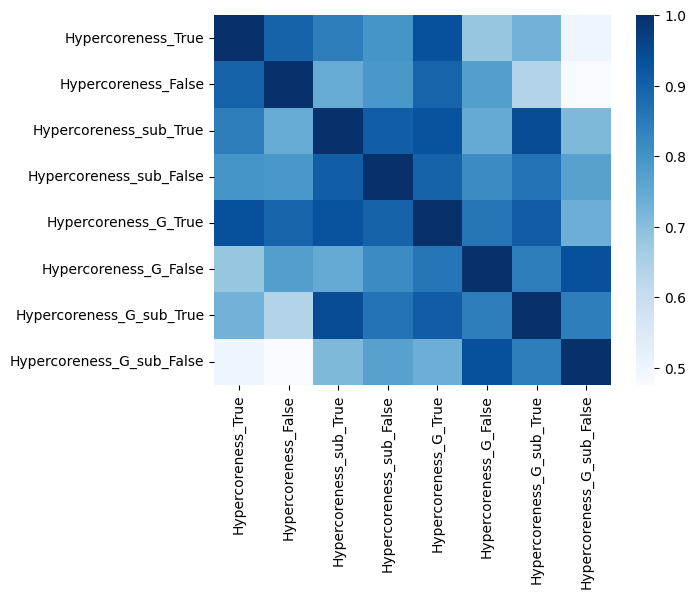

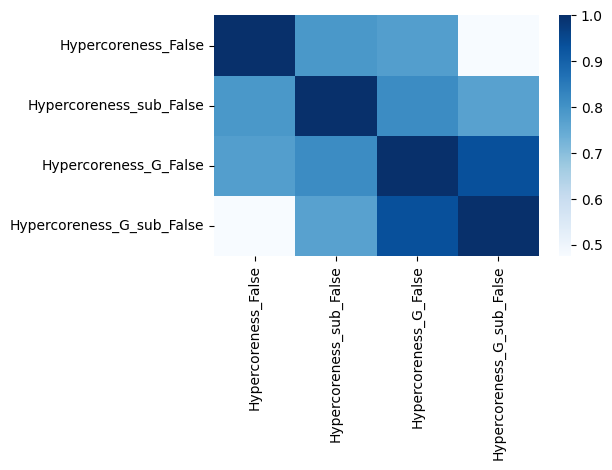

<Axes: >

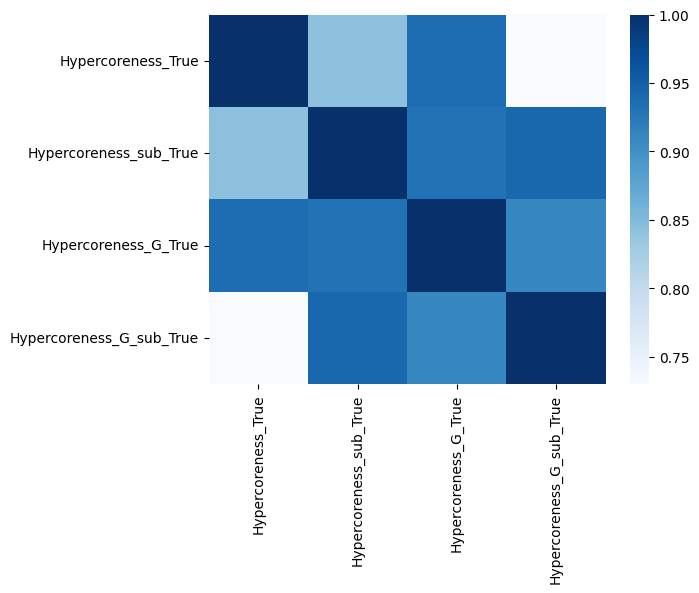

In [18]:
# Plot all correlations
sns.heatmap(EC.entities[['Hypercoreness_True', 'Hypercoreness_False', 'Hypercoreness_sub_True', 'Hypercoreness_sub_False', 'Hypercoreness_G_True', 'Hypercoreness_G_False', 'Hypercoreness_G_sub_True', 'Hypercoreness_G_sub_False']].corr(), cmap = 'Blues')
plt.show()
plt.close()
# Plot correlation without multiedges
sns.heatmap(EC.entities[[ 
        'Hypercoreness_False', 
        'Hypercoreness_sub_False', 
        'Hypercoreness_G_False', 
        'Hypercoreness_G_sub_False']].corr(), cmap = 'Blues')
plt.tight_layout()

plt.show()
plt.close()

# Plot correlations with multiedges
sns.heatmap(EC.entities[[ 'Hypercoreness_True', 'Hypercoreness_sub_True', 'Hypercoreness_G_True', 'Hypercoreness_G_sub_True']].corr(), cmap = 'Blues')

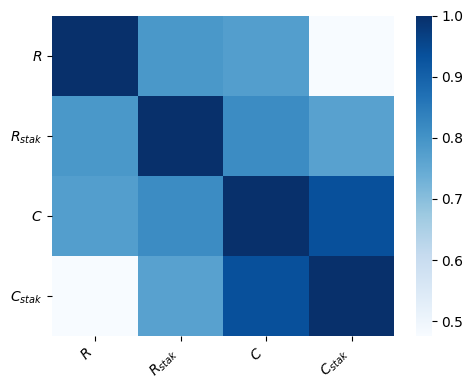

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = [
    'Hypercoreness_False',
    'Hypercoreness_sub_False',
    'Hypercoreness_G_False',
    'Hypercoreness_G_sub_False'
]

rename = {
    'Hypercoreness_False':         '$R$',
    'Hypercoreness_sub_False':      r'$R_{stak}$',
    'Hypercoreness_G_False':        '$C$',
    'Hypercoreness_G_sub_False':    r'$C_{stak}$'
}

# correlation matrix
corr = EC.entities[cols].corr()

# draw heat-map
fig, ax = plt.subplots(figsize = (5,4))
ax = sns.heatmap(corr, cmap='Blues',
                 xticklabels=False, 
                 yticklabels=False)

# apply custom labels
new_labels = [rename[c] for c in cols]
ax.set_xticks([ i+0.5 for i in range(len(cols))])
ax.set_xticklabels(new_labels, rotation=45, ha = 'right')

ax.set_yticks([i+0.5 for i in range(len(cols))])
ax.set_yticklabels(new_labels, rotation=0)

plt.tight_layout()
plt.savefig('../out/Figures/centrality_corr.pdf')

In [ ]:
corr

,Hypercoreness__False,Hypercoreness_sub_False,Hypercoreness_G_False,Hypercoreness_G_sub_False
Hypercoreness__False,1.000000,0.790228,0.710278,0.409978
Hypercoreness_sub_False,0.790228,1.000000,0.722070,0.701468
Hypercoreness_G_False,0.710278,0.722070,1.000000,0.934704
Hypercoreness_G_sub_False,0.409978,0.701468,0.934704,1.000000


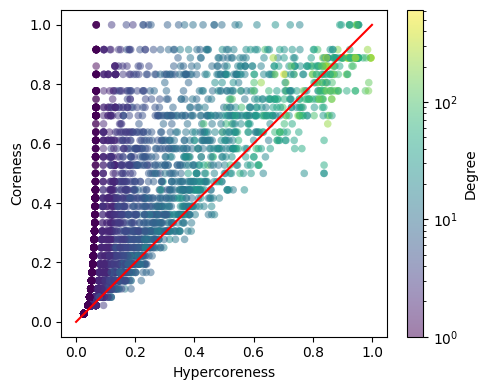

In [67]:
from matplotlib.colors import LogNorm   # <- for log-scaled colours
fig, ax = plt.subplots(figsize = (5,4))

df = EC.entities.copy()
multiedges  = False
suffix = ''
if suffix == '_sub':
    H = EC.sub_hypergraph().copy()
else:
    H = EC.H.copy()
df[f'Degree_{multiedges}'] = pd.Series( list(H.degree().values()), index = list(H.degree().keys()))

degrees = df[f'Degree_{multiedges}']  
sc = ax.scatter(
    df[f'Hypercoreness{suffix}_{False}'],
    df[f'Hypercoreness_G{suffix}_{False}'],
    c=df[f'Degree_{multiedges}'],          
    norm=LogNorm(vmin=degrees.min(), vmax=degrees.max()),
    cmap='viridis',                   
    s=30,                             
    edgecolor='none',alpha = 0.5      
)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color = 'red')

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Degree')

ax.set_xlabel('Hypercoreness')
ax.set_ylabel('Coreness')
plt.tight_layout()
plt.savefig(f'../out/Figures/hypercoreness_coreness_degree{suffix}.pdf')

## Table rank centrality

In [62]:
## Table rank centralities
centralities = ['Degree', 'Hypercoreness_sub_False']
df_cent_rank = pd.DataFrame( columns = ['Name'] + centralities)
max_rank = 50
ranks = range(1,max_rank+1)
    
cent = 'Degree'

df = EC.get_orga().sort_values(cent, ascending = False).head(max_rank)

names = dict(zip (EC.get_orga().index, EC.get_orga()['TR Name']))
df['Name'] = df.index
df['Name'] = df['Name'].apply(lambda x : names.get(x, x))
df.index = ranks

shorten = {'Non-governmental organisations, platforms and networks and similar': 'NGOs','Transport and Environment (European Federation for Transport and Environment)' :'Transport and Environment'}
df['Category of registration'] = df['Category of registration'].apply(lambda x : shorten.get(x,x))
df['Name'] = df['Name'].apply(lambda x : shorten.get(x,x))
df = df[['Name','Category of registration', 'Degree']]
df['Degree'] = df['Degree'].astype(int)
print(df[['Name','Category of registration', 'Degree']]) 

print(df[['Name','Category of registration', 'Degree']].to_latex(na_rep = ''))  



                                                 Name  \
1                                      BUSINESSEUROPE   
2                                              Google   
3                  EUROPEAN TRADE UNION CONFEDERATION   
4                           Transport and Environment   
5                                              Airbus   
6         Bureau Européen des Unions de Consommateurs   
7                       WWF European Policy Programme   
8                                    European farmers   
9   Meta Platforms Ireland Limited and its various...   
10                         European agri-cooperatives   
11  Association des Constructeurs Européens d'Auto...   
12         Bundesverband der Deutschen Industrie e.V.   
13                                    SMEunited aisbl   
14                              Microsoft Corporation   
15                      European Environmental Bureau   
16                 European Chemical Industry Council   
17                      Climate

In [63]:
## Table rank centralities
centralities = ['Hypercoreness_False', 'Hypercoreness_sub_False']
df_cent_rank = pd.DataFrame( columns = ['Name'] + centralities)
max_rank = 50
ranks = range(1,max_rank+1)
    
ranked = pd.DataFrame()
for cent in centralities:
    df = EC.get_orga().sort_values(cent, ascending = False).head(max_rank)

    names = dict(zip (EC.get_orga().index, EC.get_orga()['TR Name']))
    df['Name'] = df.index
    df['Name'] = df['Name'].apply(lambda x : names.get(x, x))
    df.index = ranks
    ranked[cent] = df['Name']

print(ranked.to_latex())

ranked.columns

\begin{tabular}{lll}
\toprule
 & Hypercoreness_False & Hypercoreness_sub_False \\
\midrule
1 & EUROPEAN TRADE UNION CONFEDERATION & European Environmental Bureau \\
2 & BUSINESSEUROPE & Climate Action Network Europe \\
3 & SMEunited aisbl & WWF European Policy Programme \\
4 & SGI Europe & ClientEarth AISBL \\
5 & ENGIE & Stichting BirdLife Europe \\
6 & RWE AG & Greenpeace European Unit \\
7 & ENEL SpA & Transport and Environment (European Federation for Transport and Environment) \\
8 & Eurelectric aisbl & Friends of the Earth Europe \\
9 & industriAll European Trade Union & Fern \\
10 & Ørsted A/S & Health & Environment Alliance \\
11 & EPIA SolarPower Europe & Global Witness \\
12 & WindEurope & BUSINESSEUROPE \\
13 & Shell Companies & TotalEnergies SE \\
14 & Transport and Environment (European Federation for Transport and Environment) & ENEL SpA \\
15 & IBERDROLA & European Chemical Industry Council \\
16 & Climate Action Network Europe & ENGIE \\
17 & European Environmental Bure

Index(['Hypercoreness_False', 'Hypercoreness_sub_False'], dtype='object')

## Community detection

In [35]:
from sknetwork.data import from_edge_list
from sknetwork.clustering import Louvain, get_modularity


def xgi_2_sknetwork(X: xgi.Hypergraph):
    edge_list = xgi.to_bipartite_edgelist(X)
    network = from_edge_list(edge_list, bipartite=True, sum_duplicates =True)
    return network

def clustering(X: xgi.Hypergraph, res =1, random_state =0):
    network = xgi_2_sknetwork(X)
    biadjacency_matrix = network.biadjacency
    louvain = Louvain(resolution = res, modularity ='Newman' , shuffle_nodes = True, random_state = random_state)
    louvain.fit(biadjacency_matrix)
    node_clusters = louvain.labels_row_
    edge_clusters = louvain.labels_col_
    node_labels = network.names
    return node_labels, node_clusters, edge_clusters

# Compute partitions with random shuffling
def df_partitions(X: xgi.Hypergraph, res: float = 1, nb_itt: int = 1):
    partitions = pd.DataFrame(index =  [i  for i in range(nb_itt)])
    partitions['Node_partition'] = partitions.index.to_series().apply(lambda x : clustering(X, res = res, random_state = int(x))[1] )
    partitions['Edge_partition'] = partitions.index.to_series().apply(lambda x : clustering(X, res = res, random_state = int(x))[2] )
    return partitions

### Stability and modularity

In [ ]:
from sklearn.metrics import normalized_mutual_info_score

def plot_stat_prop_community_detection(ax, partitions):
    # Get number of clusters
    partitions['Nb clusters'] = partitions['Node_partition'].apply(lambda x: np.max(x) +1)   
    ax[2].hist(partitions['Nb clusters'])
    ax[2].set_title('Nb clusters')
    # Compute mutual information                              
    m_i = [normalized_mutual_info_score (p1,p2) for p1,p2 in itertools.combinations(partitions['Node_partition'], 2)]
    ax[0].hist(m_i)
    ax[0].set_title('Mutual information')
    # Compute modularity of partition
    network = xgi_2_sknetwork(X)
    biadjacency_matrix = network.biadjacency
    partitions['Modularity'] = partitions.apply(
                    lambda x: get_modularity(biadjacency_matrix, x['Node_partition'] , x['Edge_partition']), axis=1
                    )
    ax[1].hist(partitions['Modularity'])
    ax[1].set_title('Modularity')
    return(ax)



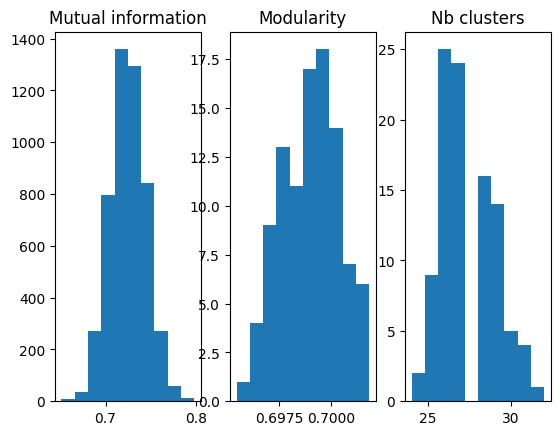

In [ ]:
nb_itt = 100
X = EC.H.copy()

#X.remove_nodes_from(EC.entities[ EC.entities['TR Name'].isna()].index)
#X.cleanup(isolates=False, singletons=False, multiedges=False, connected=True, relabel=False, in_place=True) # keep the larget connected component

partitions = df_partitions(X, nb_itt = nb_itt)
fig, ax = plt.subplots(1,3)
ax = plot_stat_prop_community_detection(ax, partitions)


In [ ]:
m_i = [normalized_mutual_info_score (p1,p2) for p1,p2 in itertools.combinations(partitions['Node_partition'], 2)]
np.std(m_i)
partitions['Modularity'].mean()

np.float64(0.6990200044397118)

In [ ]:
# Compare comfiguration random graph and empirical modularity 
# Random case
mod_rand=[]
for H in df_sim[(df_sim['mode'] == 'subdim') & (df_sim['multiedges'] == True)]['H']:
    X = H.copy()
    #X.cleanup(relabel=False, in_place=True) 

    res = 1
    nb_itt = 10
    partitions= df_partitions(X, res,nb_itt)
    # Compute modularity of nb_itt partitions
    network = xgi_2_sknetwork(X)
    biadjacency_matrix = network.biadjacency
    partitions['Modularity'] = partitions.apply(
                    lambda x: get_modularity(biadjacency_matrix, x['Node_partition'] , x['Edge_partition']), axis=1
                    )
    mod_rand.extend(list(partitions['Modularity']))

# # Empirical case
# X = EC.H.copy()
# #X.cleanup(relabel=False, in_place=True) 

# res = 1
# nb_itt = 500
# partitions= df_partitions(X, res,nb_itt)
# # Compute modularity of nb_itt partitions
# network = xgi_2_sknetwork(X)
# biadjacency_matrix = network.biadjacency
# partitions['Modularity'] = partitions.apply(
#                 lambda x: get_modularity(biadjacency_matrix, x['Node_partition'] , x['Edge_partition']), axis=1
#                 )


In [52]:

mod_emp = list(partitions['Modularity'])
print(f'Empirical mean modularity {np.mean(mod_emp)} and std {np.std(mod_emp)}')
print(f'Random mean modularity {np.mean(mod_rand)} and std {np.std(mod_rand)}')

Empirical mean modularity 0.6990200044397118 and std 0.0013476139786884255
Random mean modularity 0.514428321631467 and std 0.0007838660414322102


### Cluster Composition

In [36]:
def bar_plot_cluster_composition(ax, category_counts_per_cluster, feature, proportional = False, palette = None , alpha = 1):
   
    # Pivot to get clusters as rows and categories as columns, filling missing values with 0
    pivot_data = category_counts_per_cluster.pivot_table(index='Cluster', columns=feature, values='counts', fill_value=0)

    # Calculate proportions within each cluster
    if proportional:
        pivot_data = pivot_data.div(pivot_data.sum(axis=1), axis=0)

    # Sort each cluster's proportions by descending order for the categories
    sorted_pivot_data = np.sort(pivot_data.values, axis=1)[:, ::-1]  # Sort in descending order
    sorted_categories = np.argsort(pivot_data.values, axis=1)[:, ::-1]  # Sort in descending order

    # Prepare for plotting
    clusters = pivot_data.index
    data = sorted_pivot_data
    data_cum = data.cumsum(axis=1)

    # Get sorted category labels
    categories = pivot_data.columns
    sorted_category_labels = np.array([[categories[idx] for idx in row] for row in sorted_categories])

    # Plotting
    if palette is not None:
        palette = palette
    else:
        #palette = sns.color_palette("cubehelix", as_cmap=True)
        #palette = [palette(i / (len(categories) - 1)) for i in range(len(categories))]
        palette = sns.color_palette("hls", len(categories))


    # Create stacked bars with sorted category parts
    for i in range(len(categories)):
        heights = data[:, i]
        starts = data_cum[:, i] - heights
        #ax.bar(clusters, height=heights, bottom=starts, color=[palette[idx] for idx in sorted_categories[:, i]], label=None, alpha = alpha)
        ax.barh(clusters, width=heights, left=starts, color=[palette[idx] for idx in sorted_categories[:, i]], label=None, alpha = alpha)
   
    # Add legend with sorted categories
    handles = [plt.Rectangle((0, 0), 0, 0, facecolor=palette[i], edgecolor='none') for i in range(len(categories))]
    ax.legend(handles, categories, title=feature, bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize = 6)

    # Adding labels and title
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Number of organizations')
    return(ax)
    

In [68]:
X = EC.H.copy()
#X.cleanup(relabel=False, in_place=True) 

res = 1
nb_itt = 500
partitions = df_partitions(X, res,nb_itt)
# Compute modularity of nb_itt partitions
network = xgi_2_sknetwork(X)
biadjacency_matrix = network.biadjacency
partitions['Modularity'] = partitions.apply(
                lambda x: get_modularity(biadjacency_matrix, x['Node_partition'] , x['Edge_partition']), axis=1
                )
                


In [69]:
# Get the index of the partition with the highest modularity
max_mod_index = int(partitions.loc[partitions.Modularity == partitions.Modularity.max()].index[0])
node_labels, node_clusters, edge_clusters = clustering(X, res =res , random_state = max_mod_index)
# Assign nodes to clusters 
df = pd.DataFrame({'Cluster': node_clusters}, index= node_labels)
EC.entities['Cluster']= df['Cluster']


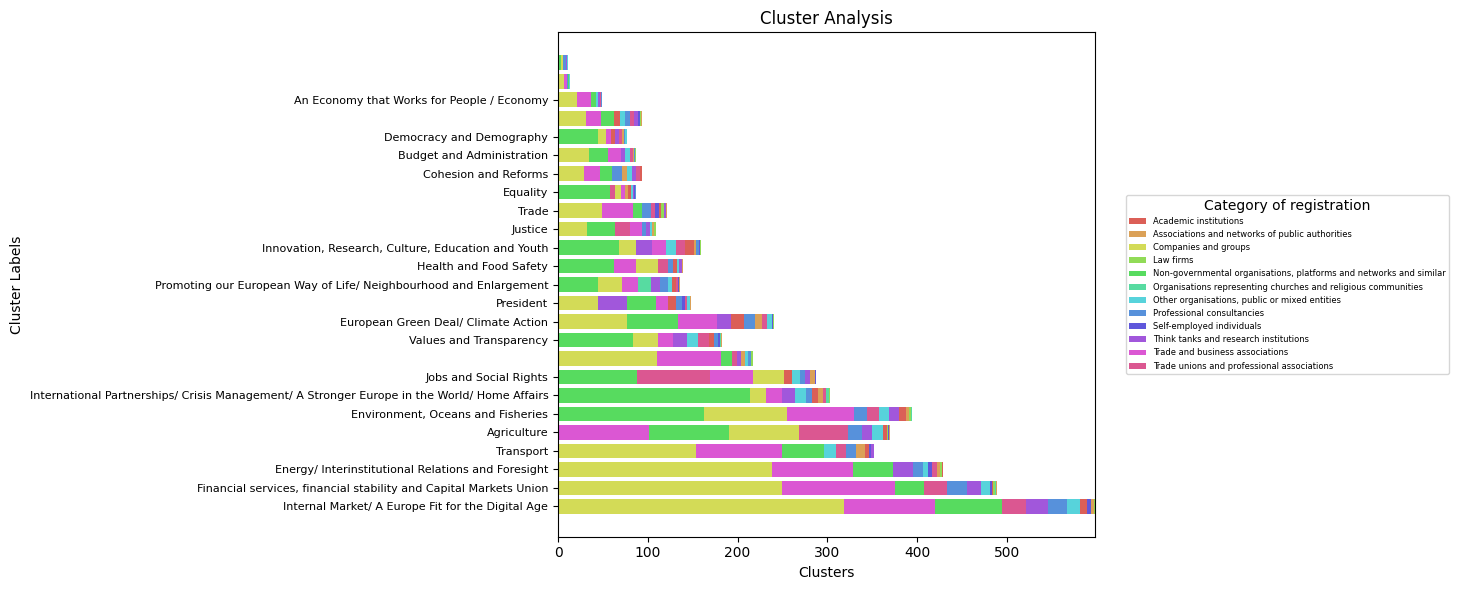

In [ ]:
df = pd.read_csv('../data/commissions_portfolio.csv', index_col = 'Name of EC representative')
df['Cluster'] = EC.entities[EC.entities['Category of registration'] == 'Commissioner']['Cluster']
df = df.groupby('Cluster').agg(lambda x: tuple( y for y in x.dropna()))['Portfolio']
# Create a mapping from cluster numbers to their labels
cluster_labels = {idx: '/ '.join(set(val)) for idx, val in zip(df.index, df)}

fig, ax = plt.subplots(figsize=(15, 6))
y_values = list(cluster_labels.keys())  
x_values = range(len(y_values))        

feature = 'Category of registration'
category_counts_per_cluster = EC.entities[EC.entities['Type']=='Organization'].groupby(['Cluster',feature ]).size().reset_index(name='counts')

ax = bar_plot_cluster_composition(ax, category_counts_per_cluster, feature, palette =sns.color_palette("hls", len(category_counts_per_cluster[feature].unique())), proportional = False)

# Set the y-axis labels
ax.set_yticks(list(cluster_labels.keys()))
ax.set_yticklabels([cluster_labels[idx] for idx in cluster_labels.keys()], fontsize=8)

# Add labels and title
ax.set_ylabel('Cluster')
ax.set_xlabel('Cluster size')
ax.set_title('Cluster Analysis')


plt.tight_layout()
plt.savefig(f'../out/Figures/H_cluster_composition_{feature}.pdf')

In [43]:

nb_itt = 1
res = 1
partitions = df_partitions(X, res,nb_itt)
# Compute modularity of partition
network = xgi_2_sknetwork(X)
biadjacency_matrix = network.biadjacency
partitions['Modularity'] = partitions.apply(
                lambda x: get_modularity(biadjacency_matrix, x['Node_partition'] , x['Edge_partition']), axis=1
                )
# Get the index of the partition with the highest modularity
max_mod_index = int(partitions.loc[partitions.Modularity == partitions.Modularity.max()].index[0])

node_labels, node_clusters, edge_clusters = clustering(X, res =res , random_state = max_mod_index)
df = pd.DataFrame({'Cluster': node_clusters}, index= node_labels)
EC.entities['Cluster']= df['Cluster']



# Group by 'Cluster' and 'Category of registration' to get counts
feature = 'NACE'
category_counts_per_cluster = EC.entities.loc[list(X.nodes)].groupby(['Cluster',feature ]).size().reset_index(name='counts')

ax[1,1] = bar_plot_cluster_composition(ax[1,1], category_counts_per_cluster, feature, proportional = False)
# ax[1] = bar_plot_cluster_composition(ax[1], category_counts_per_cluster, feature, proportional = True)
# #ax[0].set_title(f'resolution={res}')
# ax[1].get_legend().remove()


plt.tight_layout()
#plt.savefig('../out/Figures/H_orga_cluster_composition_NACE.pdf')

TypeError: 'Axes' object is not subscriptable

In [ ]:
all_clusters = set(EC.entities['Cluster'].unique())
com_in_cluster = set(list(EC.entities[EC.entities['Category of registration'] == 'Commissioner']['Cluster']))
com_not_in_cluster = all_clusters - com_in_cluster
len(com_in_cluster) / len(all_clusters)



0.8846153846153846

In [70]:
# Save graph viz with clustrers attribute

# X = EC.H.copy()
# X.remove_nodes_from(EC.entities[ EC.entities['TR Name'].isna()].index)
# entities = EC.entities.loc[list(X.nodes)].copy()

X = EC.H.copy()
entities = EC.entities.copy()

B = nx.Graph()
for node, cluster in zip(entities.index, entities['Cluster']):
    B.add_node(node, bipartite = 'node', cluster = cluster)
for edge in X.edges:
    B.add_node(edge, bipartite = 'edge')
edge_list = xgi.to_bipartite_edgelist(X)
B.add_edges_from(edge_list)

label = dict(zip( entities[entities['TR Name'].notna()].index ,entities[entities['TR Name'].notna()]['TR Name']))
B = nx.relabel_nodes(B, label)

attr = dict(zip(entities['TR Name'], entities['Category of registration']))
attr.update( dict(zip(entities.index, entities['Category of registration'])))
nx.set_node_attributes(B, attr,'Partition')

attr = dict(zip(entities['TR Name'], entities['Type']))
attr.update( dict(zip(entities.index, entities['Category of registration'])))
nx.set_node_attributes(B, attr,'Type')


nx.write_gexf(B, "../out/graph_viz/Network_clusters.gexf")


In [ ]:
label = dict(zip(EC.entities.index, EC.entities['TR Name']))
X = EC.H.copy()
X.remove_nodes_from(EC.entities[ EC.entities['TR Name'].isna()].index)
B = XGI_2_nxBipartite(X)
B = nx.relabel_nodes(B, label)
attr = dict(zip(EC.entities['TR Name'], EC.entities['Category of registration']))
#nx.set_node_attributes(B, partition_attr,'Partition')
nx.set_node_attributes(B, attr,'Partition')

nx.write_gexf(B, "../out/orga.gexf")

# Sensitivity analysis fuzzy matching

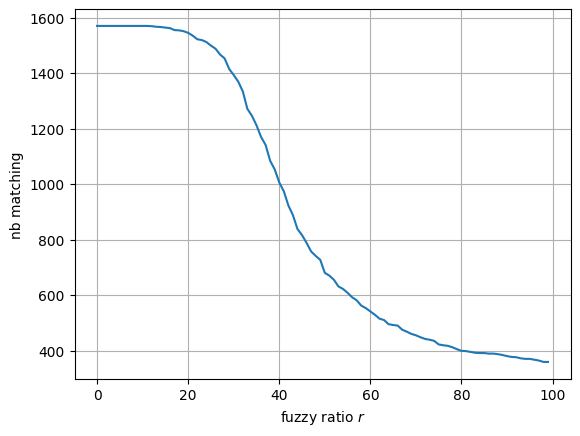

In [ ]:
from process_meetings import load_meetings, merge_duplicated_meetings, add_relative_commission
date_start = '2019-12-01'
date_end = '2024-11-30'


# Load and process all meetings
meetings = load_meetings('../data/', date_start, date_end, fuzzy_ratio = 100)
meetings.rename(columns={
            'Name of EC representative':    'EC member',
            'Date of meeting':               'Date',
            'Transparency register ID':      'TR ID',
            'Name of DG - full name':        'Name of DG',
            'Subject of the meeting':        'Subject'
        }, inplace=True)
meetings['Date'] = pd.to_datetime(meetings['Date'])
for col in ['EC member','Title of EC representative','TR ID']:
    meetings[col] = meetings[col].str.split(',').apply(tuple)

meetings = add_relative_commission(meetings, '../data/')
#meetings = merge_duplicated_meetings(meetings)
from fuzzywuzzy import fuzz

def pairwise_fuzzy(group):
    """
    Given a Series of meeting subjects, compute the partial-ratio
    for every unordered pair and return the result as a DataFrame.
    """
    records = []
    subj_list = group.tolist()

    for s1, s2 in itertools.combinations(subj_list, 2):
        records.append({
            "Subject_1": s1,
            "Subject_2": s2,
            "Ratio":     fuzz.partial_ratio(s1, s2)
        })

    # Return an empty frame if the group has < 2 rows
    return pd.DataFrame(records)

# -------------------------------------------------------------
# Apply the function to each (Date, TR ID) block
# -------------------------------------------------------------
pair_df = (
    meetings
    .groupby(["Date", "TR ID"])["Subject"]
    .apply(pairwise_fuzzy)          # each group → small DataFrame
    .reset_index(level=[0,1])       # keep Date and TR ID as columns
    .dropna(subset=["Ratio"])       # drop empty groups
)
pair_df.sort_values('Ratio', ascending = False).to_csv('../out/fuzzy_ratio.csv')
nb_matching = []
for r in range(0,100):
    nb_matching.append(len(pair_df[pair_df['Ratio']>r]))


In [ ]:

plt.plot(range(0,100), nb_matching)
plt.xlabel('fuzzy ratio $r$')
plt.ylabel('nb matching')
plt.grid()
plt.savefig('../out/Figures/fuzzy.pdf')